# APS PMDI canister fluorescence

Post processing of X-ray canister fluorescence data with KI and BaSO4.
First step - read scans, integrate spectral peaks, normalize flourescence signals and collate output.

The routines in this first script do not depend on sample conditions or position - only spectral content and countrates.

Data collected by Daniel Duke, Lingzhe Rao & Alan Kastengren
@ Advanced Photon Source, Argonne National Laboratory, Lemont, Illinois USA
November, 2022.

    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2022 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 13/02/2023
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import h5py
import numpy as np
import scipy.optimize, scipy.integrate
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Read data and extract useful variables
This code is suited to non time resolved data where the entire spectral dump can be used and ROIs are not used.
Suitable for 1D or 2D scans.

In [2]:
# Read HDF5 file from beamline, extract useful independent and dependent variables
def readScan(filename):
        H=h5py.File(filename,'r')
        data={}
        
        data['spectrum'] = H['7bmDante:mca1.VAL'][...]
        data['spectrum'][...,-1] = 0.
        
        data['fastCounts'] = H['7bmDante:dante1:InputCountRate'][...]
        data['slowCounts'] = H['7bmDante:dante1:OutputCountRate'][...]
        data['countTime'] = H['7bmDante:dante1:ElapsedReal'][...]
        
        minEnergy=-2.5 # keV, set by Dante MCA control
        maxEnergy=55. # keV, set by Dante MCA control
        data['energy'] = np.linspace(minEnergy, maxEnergy, data['spectrum'].shape[-1])
        
        try:
            data['x'] = H['7bmb1:aero:m2.RBV'][...] # SAMPLE_X
        except KeyError:
            data['x'] = None
        
        try:
            data['y'] = H['7bmb1:aero:m1.RBV'][...] # SAMPLE_Y
        except KeyError:
            data['y'] = None
            
        try:
            data['shakeTimer'] = H['7bmb1:SG1:UpCntr-2_COUNTS'][...]/10. # convert to sec
        except KeyError:
            pass
        
        data['shotCounter'] = H['7bmb1:SG1:UpCntr-1_COUNTS'][...]
        data['diamondMonitor'] = H['7bmb1:3820:scaler1.S4'][...] / H['7bmb1:3820:scaler1.S1'][...]
        data['pinDiode'] = H['7bmb1:3820:scaler1.S3'][...] / H['7bmb1:3820:scaler1.S1'][...]
        data['SRcurrent'] = H['S:SRcurrentAI.VAL'][...]
        
        H.close()
        return data

### Read a test file and have a look at it to check that the code works
Use a simple vertical table scan as a test case

<IPython.core.display.Javascript object>


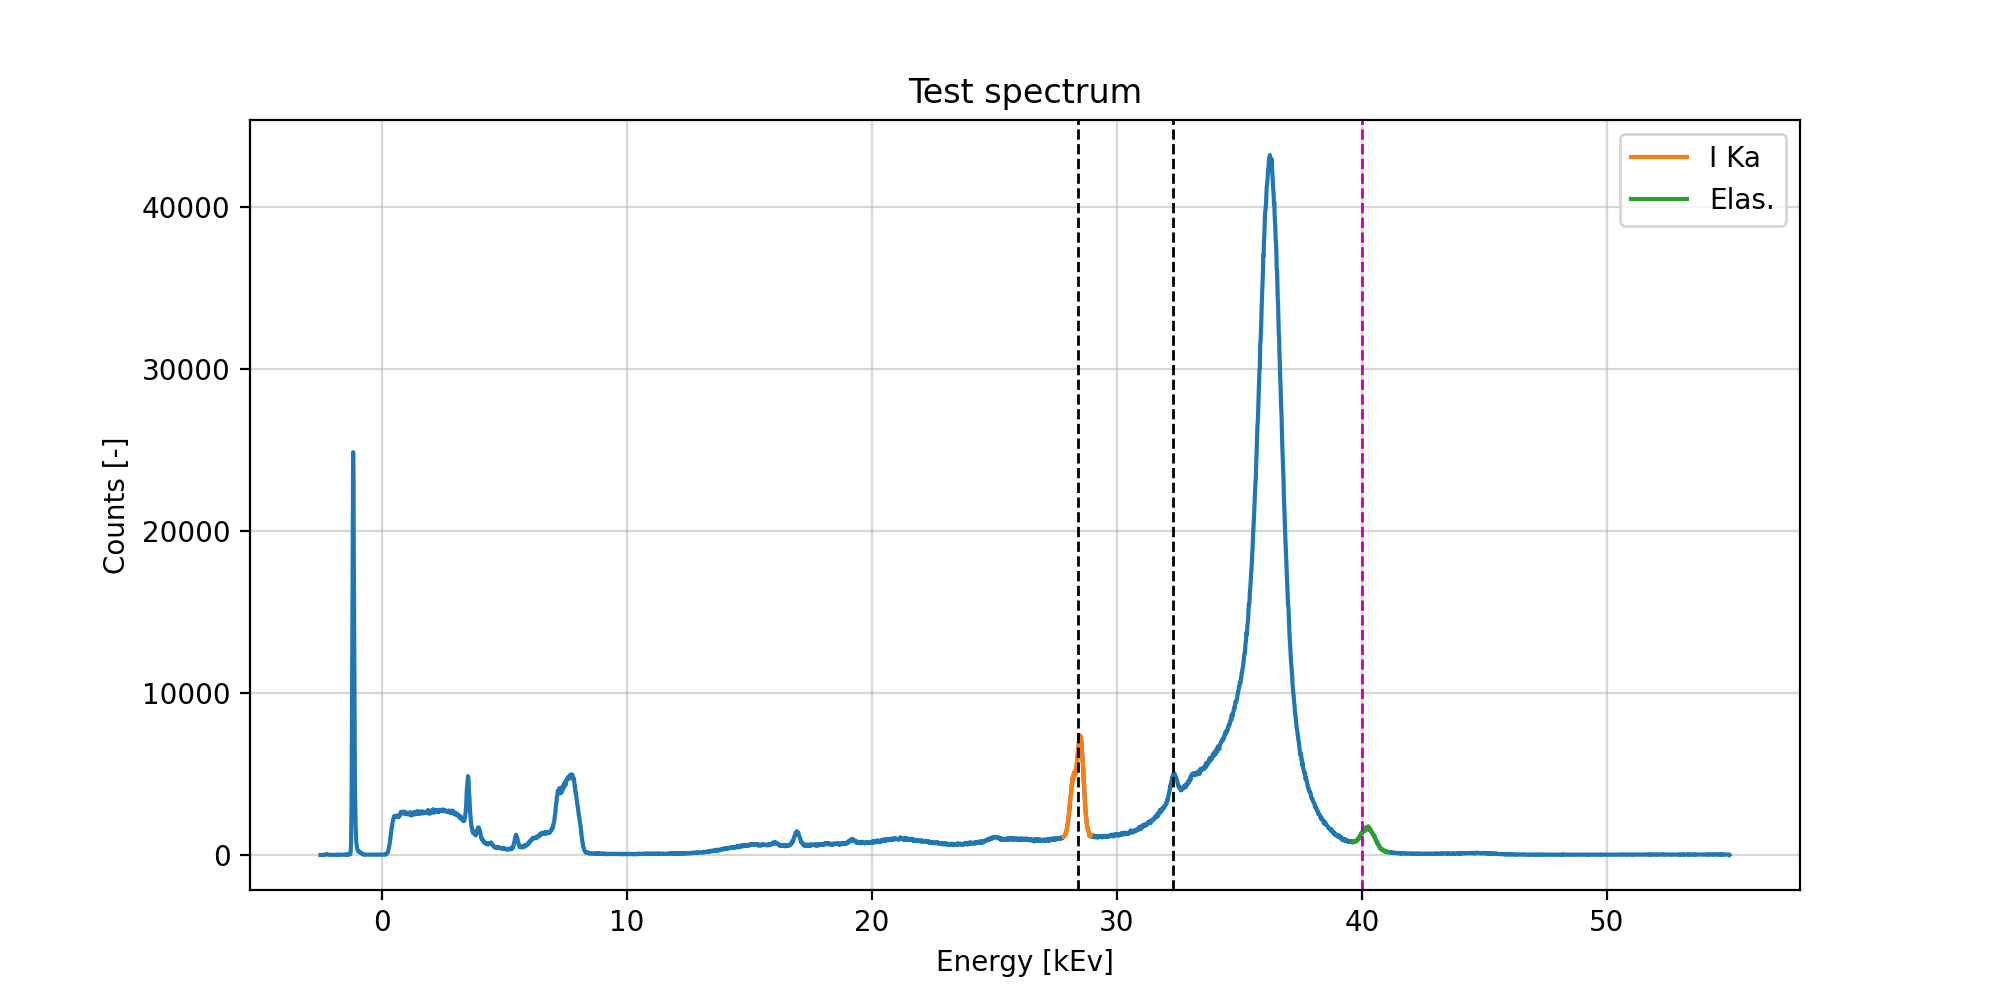

<IPython.core.display.Javascript object>


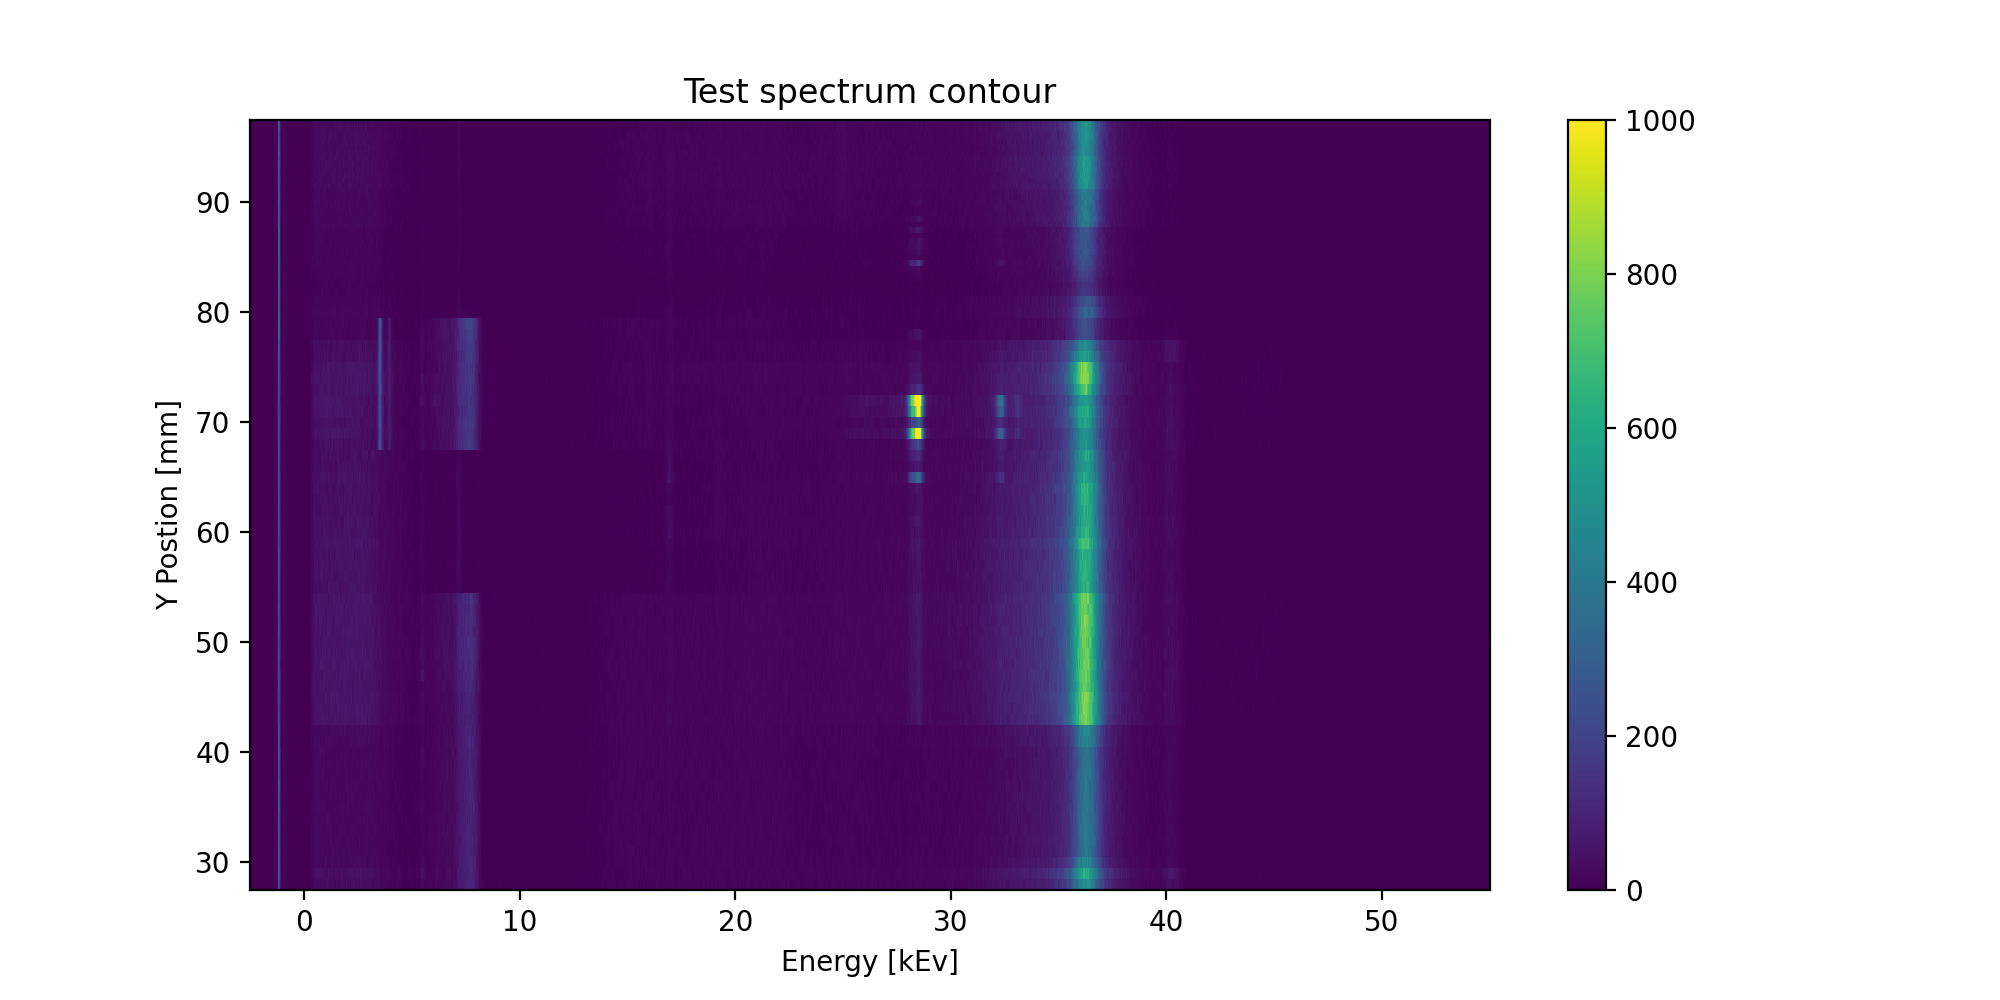

In [3]:
d=readScan("processed_data/7bmb1_4049.h5") #  1D scan (vert)

fig=plt.figure(figsize=(10,5)); plt.grid(alpha=.5)
plt.plot(d['energy'],np.nansum(d['spectrum'],axis=0))
plt.plot(d['energy'][2160:2240],np.nansum(d['spectrum'][:,2160:2240],axis=0),label='I Ka')
plt.plot(d['energy'][3000:3100],np.nansum(d['spectrum'][:,3000:3100],axis=0),label='Elas.')
# known energies for sanity check:
plt.axvline(28.4,ls='--',c='k',lw=1) 
plt.axvline(32.294,ls='--',c='k',lw=1)
plt.axvline(40,ls='--',c='m',lw=1)
plt.title("Test spectrum"); plt.xlabel('Energy [kEv]'); plt.ylabel('Counts [-]'); plt.legend()

fig=plt.figure(figsize=(10,5))
xx,yy = np.meshgrid(d['energy'],d['y'])
h_=plt.pcolormesh(xx,yy,d['spectrum'],shading='nearest',vmax=1000)
plt.title('Test spectrum contour'); plt.xlabel('Energy [kEv]');  plt.ylabel('Y Postion [mm]')
plt.colorbar(h_);

## 2. Post-process the spectrum to extract the useful fluorescence peaks

Integrate portions of the spectrum, remove background, make dead-time corrections (ie detector saturation)

In [4]:
def calcR2(f, xdata, ydata, popt):
    residuals = ydata- f(xdata, *popt)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    return 1 - (np.nansum(residuals**2) / ss_tot)

# Integrate full spectrum (for time average data), removing background level from spectral peaks.
# bkpoints is how many data points to use at each end of the integration window as the background fit.
# other arguments are for diagnostic plot generation only (not used in calculations).
def integratePeaks(data, bkpoints=20, showSamplePlots=True, nPlot=8, nPlotOffset=0):
    
    # List of peaks with energy bounds in keV - manually coded
    peaks = {'I Ka': (27.4,29.4),\
             'I Kb': (31.5,33),\
             'Ba Ka': (31,33),\
             'Compton': (33,39.5),\
             'Elastic': (39,41.5)}
    
    # Background fitting function
    quadbkfun = lambda x,a,b,c: np.abs(a)*x**2 +b*x +c 
    linbkfun = lambda x,a,b: a*x + b
    
    # Create diagnostic plot
    m=0
    if showSamplePlots:
        plt.rc('font', size=8)
        fig=plt.figure(figsize=(10,12))
        plt.subplots_adjust(hspace=1.)
        
    
    # Create dictionary to hold results
    peak_int = {}; peak_snr = {}; peak_energy = {}
    
    for p in peaks:

        # Create arrays to hold results
        peak_int[p] = np.zeros(data['spectrum'][...,0].shape)
        peak_snr[p] = np.zeros(data['spectrum'][...,0].shape)
        peak_energy[p] = np.zeros(data['spectrum'][...,0].shape)
        
        # Get indices for integration
        a = np.where(data['energy']>=peaks[p][0])[0][0]
        b = np.where(data['energy']>=peaks[p][1])[0][0]
        energy = data['energy'][a:b]
        
        # This index is purely for making graphs - will show the middle few points
        n=-int(np.product(data['spectrum'][...,0].shape)/2)+nPlot/2 + nPlotOffset
        
        # Loop thru spectra
        for spect_index, _s in np.ndenumerate(data['spectrum'][...,0]):
            spect = data['spectrum'][(*spect_index, slice(None))]
            
            # Fit to the background.
            bkdrift = np.abs(spect[b]-spect[a])/(np.nanmax(spect[a:b])-np.nanmin(spect[a:b]))
            if bkdrift>0.25:  # If the background is curving enough to justify a higher order fit;
                mybkfun = quadbkfun ;         fc='r'
            else:  # Default linear fit to bkgnd
                mybkfun = linbkfun ;          fc='g'
            bk_indices = np.hstack((np.arange(a,a+bkpoints+1),np.arange(b-bkpoints,b+1)))
            bk_energy = data['energy'][bk_indices]
            try:
                popt,pcov = scipy.optimize.curve_fit(mybkfun, bk_energy,spect[bk_indices])
            except RuntimeError:
                mybkfun = linbkfun; fc='g'
                popt,pcov = scipy.optimize.curve_fit(mybkfun, bk_energy,spect[bk_indices])
            r2=calcR2(mybkfun,bk_energy,spect[bk_indices],popt)
            
            # Count the number of hits in the peak
            signal_counts = np.nansum(spect[a:b])
            bkgnd_counts = np.nansum(mybkfun(energy,*popt)) #approximation

            # Check for background over-fitting ;  fallback to linear fit if required
            if ((bkgnd_counts > signal_counts) | (r2<0.1)) & (mybkfun != linbkfun):
                mybkfun = linbkfun
                bk_indices = np.hstack((np.arange(a,a+bkpoints+1),np.arange(b-bkpoints,b+1)))
                bk_energy = data['energy'][bk_indices]
                popt,pcov = scipy.optimize.curve_fit(mybkfun, bk_energy,spect[bk_indices])
                r2=calcR2(mybkfun,bk_energy,spect[bk_indices],popt)
                bkgnd_counts = np.nansum(mybkfun(energy,*popt)) #approximation

            # Compute Poisson statistics
            if bkgnd_counts > signal_counts: snr = np.nan # If this happens, probably no peak.
            else: snr = np.sqrt(signal_counts - bkgnd_counts) # Poisson noise

            # Integrate the spectrum & background in the relevant region
            signal_integral = scipy.integrate.simps(spect[a:b],x=energy)
            bkgnd_integral = scipy.integrate.simps(mybkfun(energy,*popt),x=energy)

            # Find the peak energy (useful for Compton)
            pki = np.where(spect[a:b]==np.nanmax(spect[a:b]))[0][0]
            
            # Save results
            peak_int[p][spect_index] = signal_integral - bkgnd_integral
            peak_snr[p][spect_index] = snr
            peak_energy[p][spect_index] = energy[pki]
                
            # Generate a diagnostic plot
            if showSamplePlots & ((n>=0)&(n<nPlot)&(m<len(peaks))):
                ax=fig.add_subplot(int(nPlot),len(peaks),int(1+m+n*len(peaks)))
                ax.plot(data['energy'],spect)
                ax.plot(energy,spect[a:b],label=p)
                ax.fill_between(energy,mybkfun(energy,*popt),spect[a:b],alpha=.5,facecolor=fc)
                ax.scatter(bk_energy, mybkfun(bk_energy, *popt),marker='+',lw=1,c=fc,zorder=1)
                plt.xlabel('Energy [kEv]'); ax.set_xlim(peaks[p][0]-1,peaks[p][1]+1)
                ax.set_ylim(0,1.2*np.nanmax(spect[a:b]))
                plt.title('%s @pos %s %.2f' % (p,spect_index,r2), fontsize=8)
            n+=1
            
        m+=1
    
    return peak_int, peak_snr, peak_energy

<IPython.core.display.Javascript object>


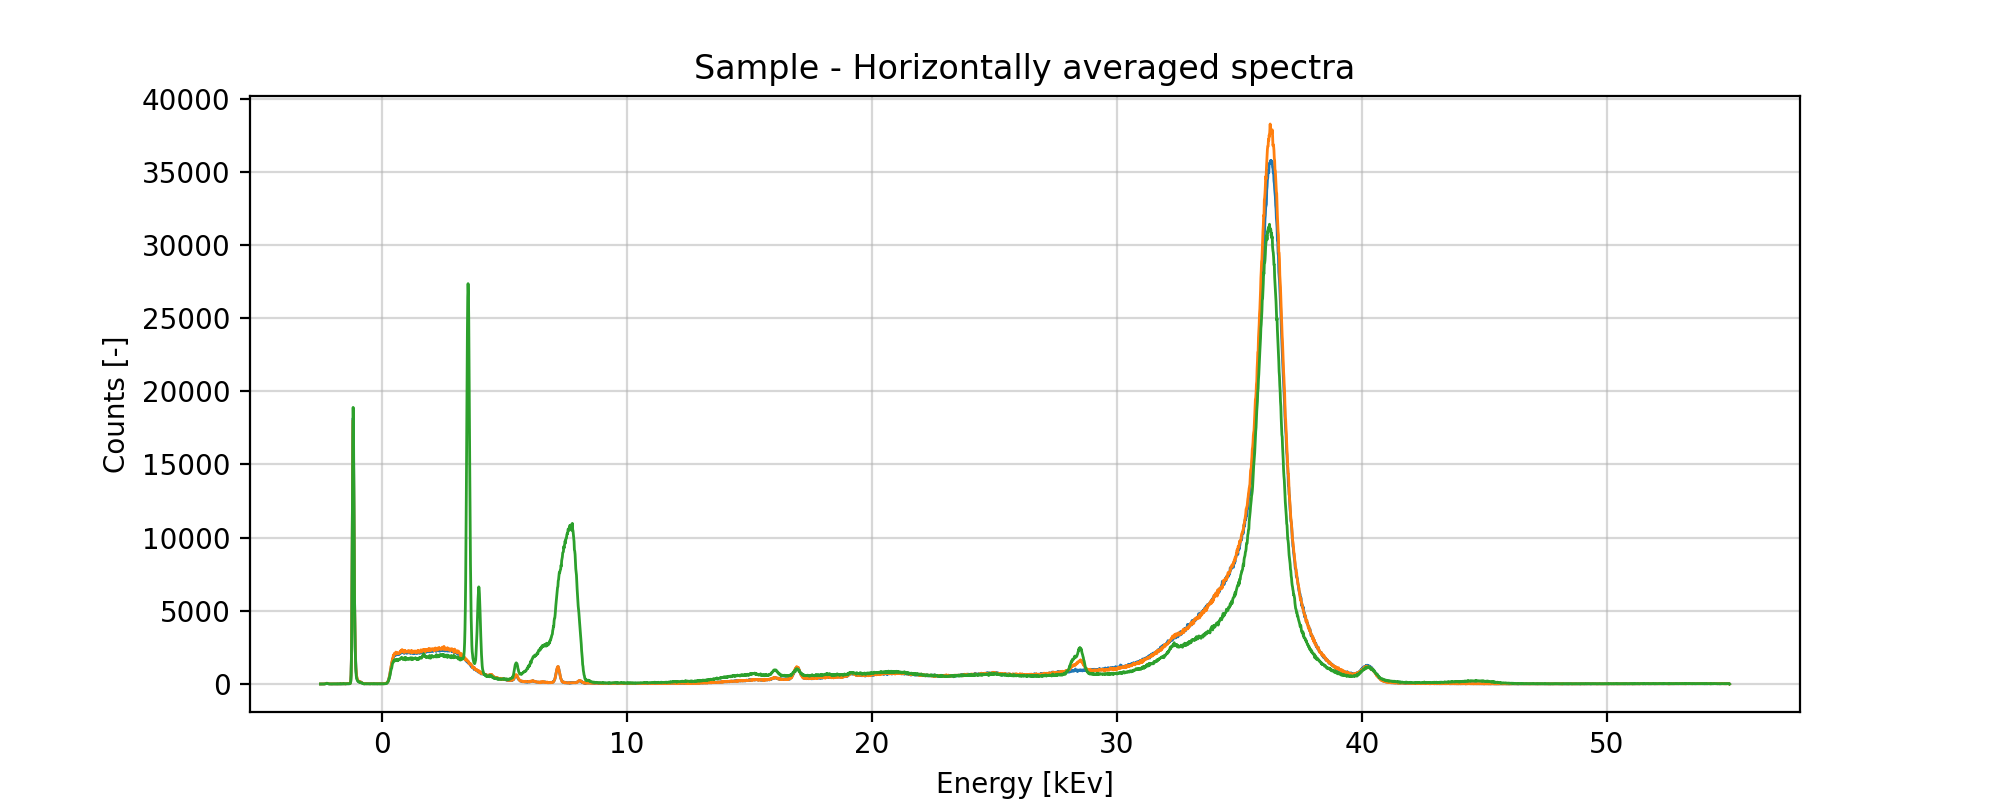

<IPython.core.display.Javascript object>


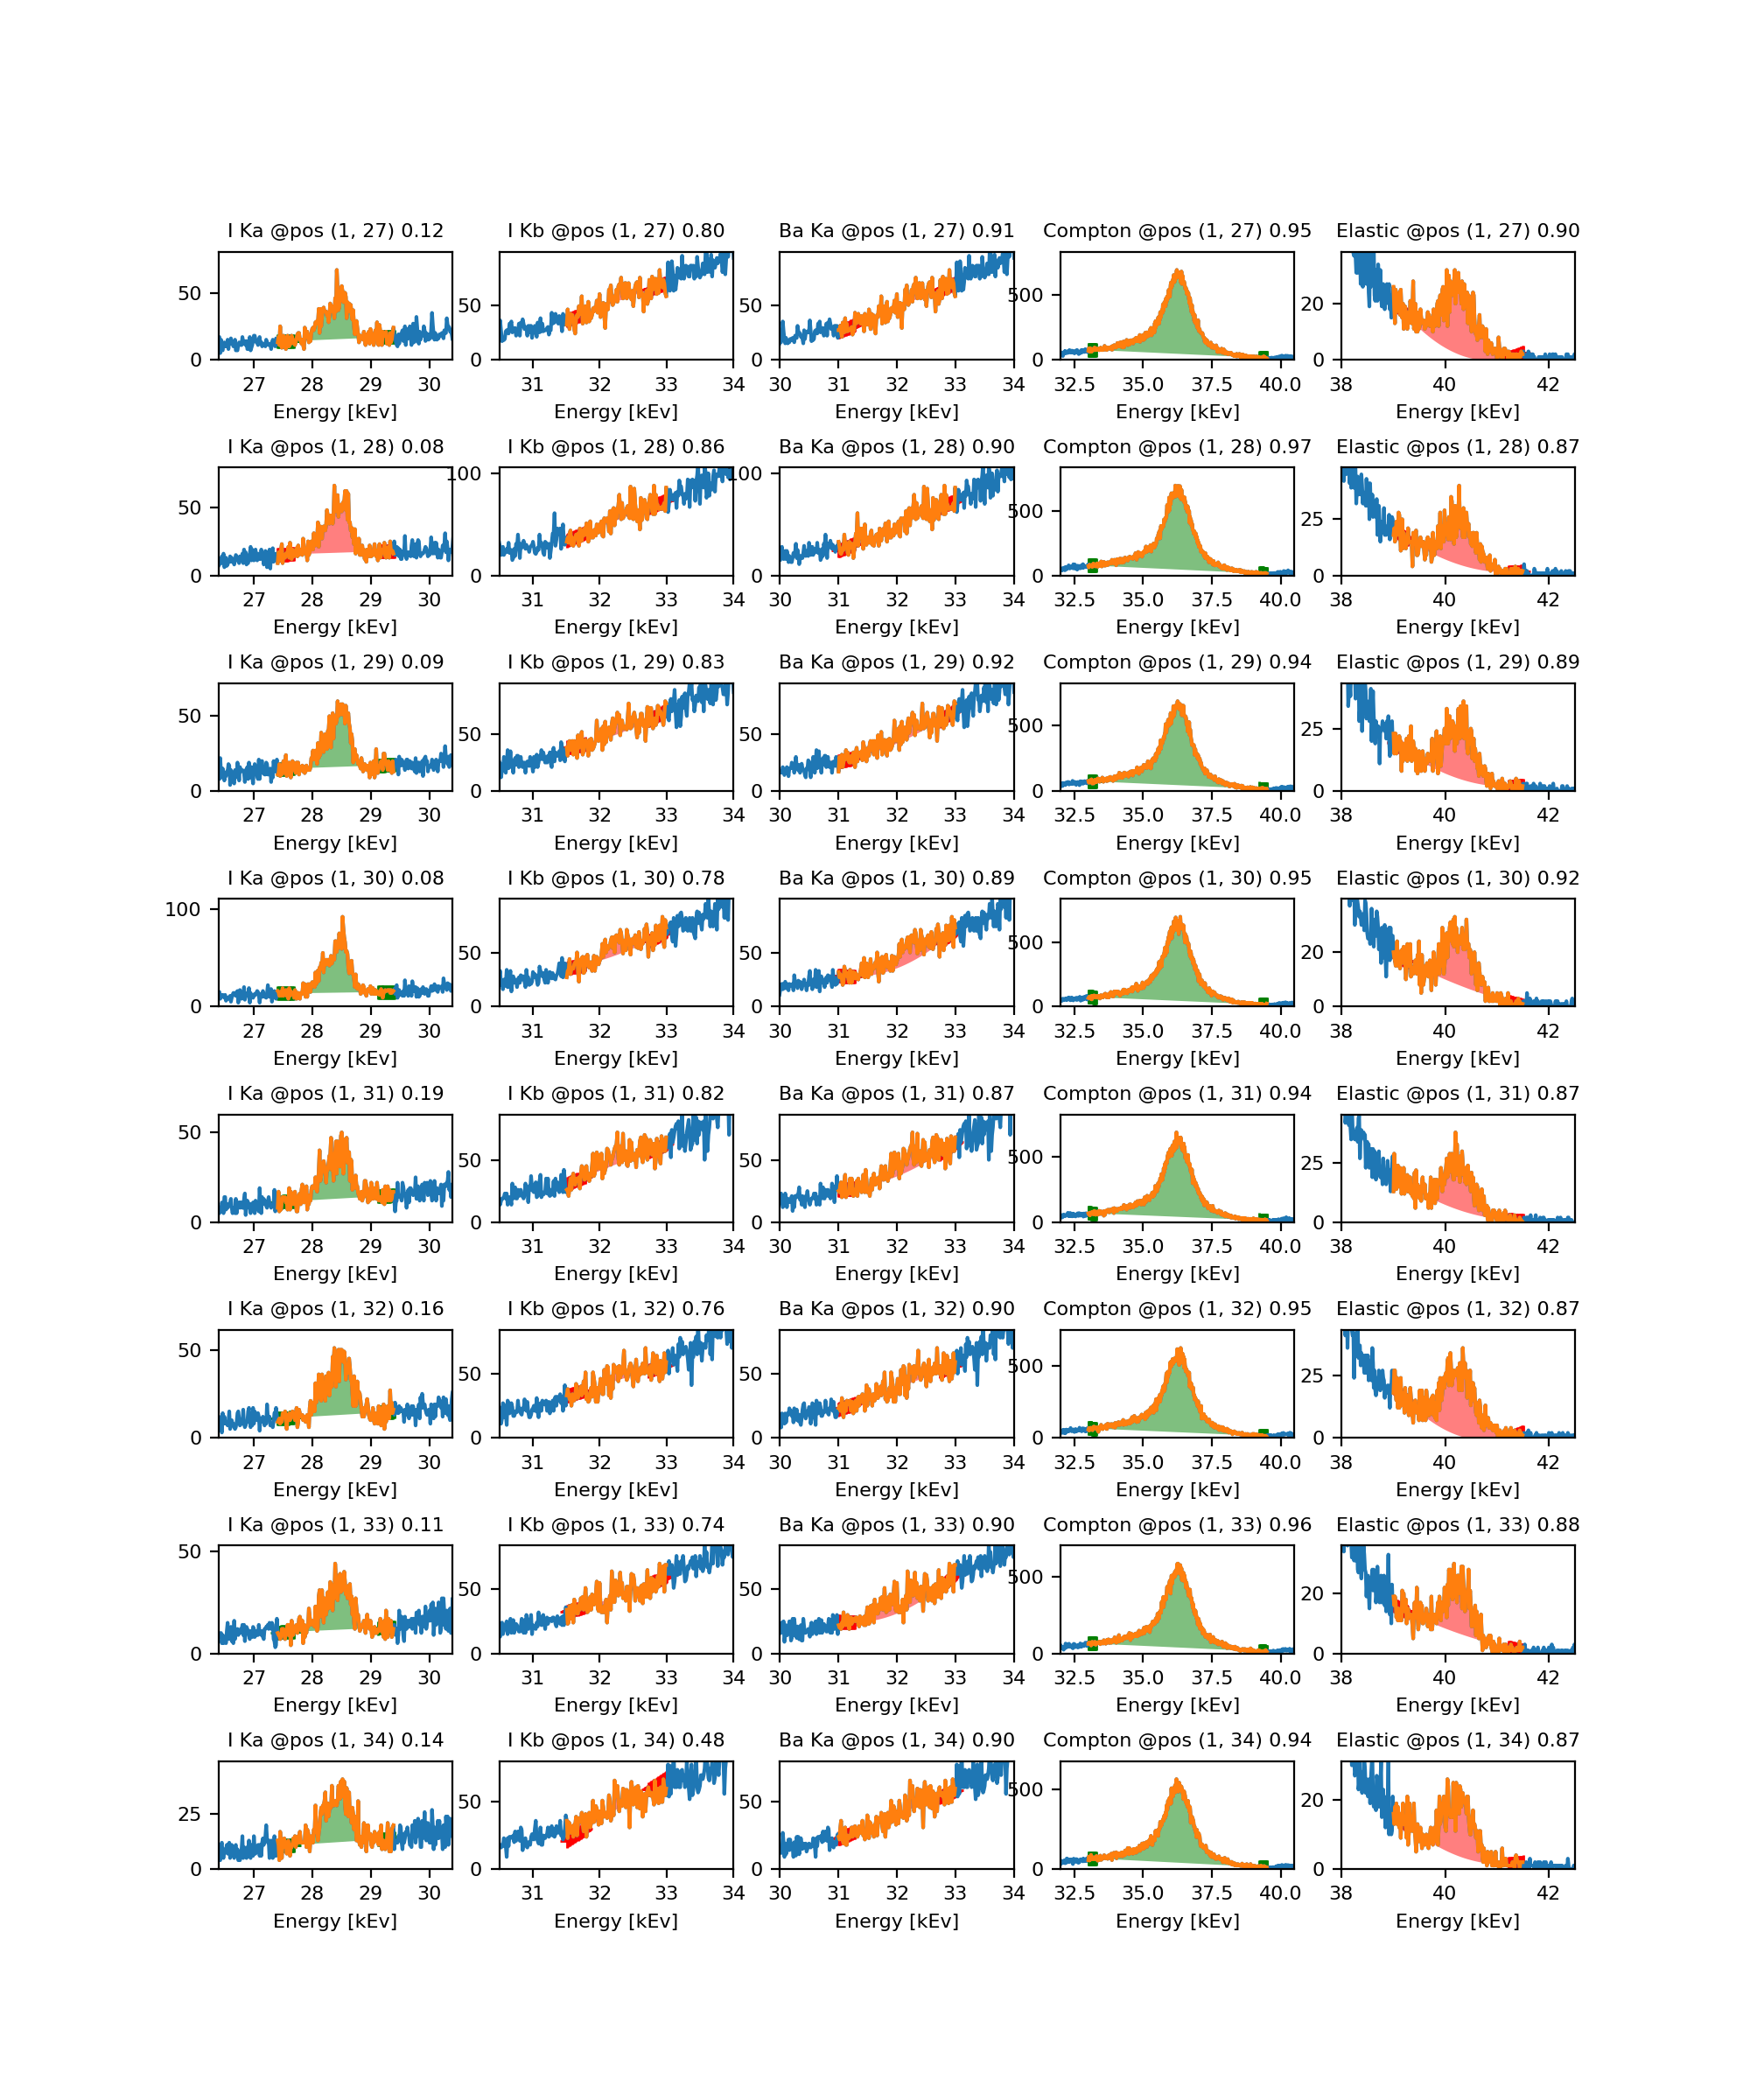

In [5]:
d=readScan("processed_data/7bmb1_4135.h5") #  2D Iodine scan (horiz x vert)
#d=readScan("processed_data/7bmb1_4049.h5") #  1D Iodine scan (vert)
#d=readScan("processed_data/7bmb1_4294.h5") #  1D Barium scan (vert)

# Plot the spectra for sanity check
fig=plt.figure(figsize=(10,4)); plt.grid(alpha=.5)
if len(d['spectrum'].shape)>2:
    for j in range(d['spectrum'].shape[0]): 
        plt.plot(d['energy'],np.nansum(d['spectrum'][j,...],axis=0),lw=1)
    plt.title("Sample - Horizontally averaged spectra")
else:
    plt.plot(d['energy'],np.nansum(d['spectrum'],axis=0))
    plt.title("Sample - Spatially averaged spectrum")
plt.xlabel('Energy [kEv]'); plt.ylabel('Counts [-]')

# Integrate peaks with diagnostic plots on
integrals, snr, peakenergy = integratePeaks(d);

<IPython.core.display.Javascript object>


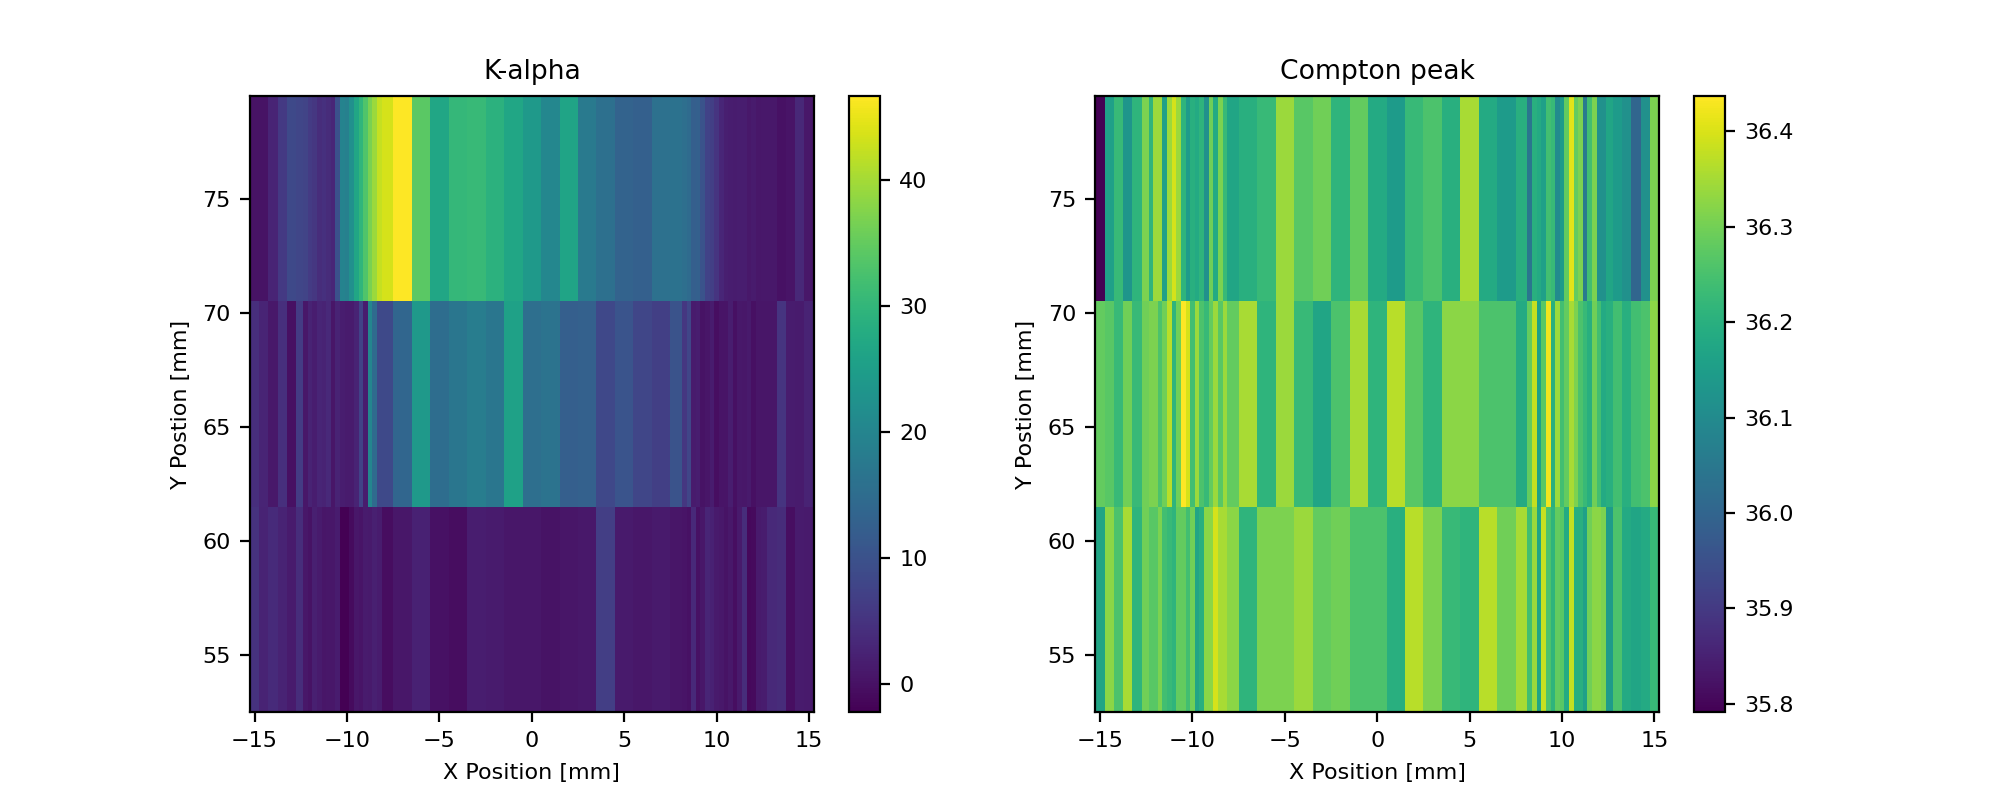

In [7]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(121)
h_=ax.pcolormesh(d['x'],d['y'],integrals['I Ka'],shading='nearest')
plt.title('K-alpha'); plt.xlabel('X Position [mm]');  plt.ylabel('Y Postion [mm]')
plt.colorbar(h_);

ax=fig.add_subplot(122)
h_=ax.pcolormesh(d['x'],d['y'],peakenergy['Compton'],shading='nearest')
plt.title('Compton peak'); plt.xlabel('X Position [mm]');  plt.ylabel('Y Postion [mm]')
plt.colorbar(h_);

## 3. Normalize the magnitude of the integrals
Correct for SR current and detector dead time which can cause bias in the count rate.

In [9]:
# FROM ALAN #################################################################################

def fdead_time_zero_function(actual_countrate,observed_countrate,time_constant):
    '''Used for finding actual countrate based on dead time function.
    '''
    return actual_countrate * np.exp(-time_constant * actual_countrate) - observed_countrate

def fcorrect_deadtime(raw_fluorescence,slow_events,fast_events,
                      integration_time,fast_filter_time_constant=3.15e-7):
    '''Corrects for dead time.  Uses Eq. 1 from NIM 2010 Walko et al.
    paper to correct for dead time in the fast filter.  Thereafter,
    use corrected fast events/slow as a constant multiplier to correct for
    dead time.
    '''
    #Convert fast counts into a countrate
    fast_countrate = fast_events / integration_time
    #Perform fitting to correct fast countrate.  Do it on the flattened
    #array to retain generality if the array is multidimensional.
    reshaped_fast = fast_countrate.flatten()
    fitted_fast_countrate = np.zeros_like(reshaped_fast)
    for i in range(len(reshaped_fast)):
        try:
            fitted_fast_countrate[i] = scipy.optimize.brentq(fdead_time_zero_function,reshaped_fast[i]-50000,reshaped_fast[i]+1e5,
                        (reshaped_fast[i],fast_filter_time_constant))
        except RuntimeError:
            fitted_fast_countrate[i] = reshaped_fast[i]
    fitted_fast_countrate = fitted_fast_countrate.reshape(fast_countrate.shape)
    #Compute live time from the slow and fast events.
    #Take care of NAN values, which may happen when fast_events=0.
    #For these points, assume dead time = 0, since there must be little or no flux.
    live_time = np.nan_to_num(slow_events/fitted_fast_countrate/integration_time)
    #
    #Divide the fluorescence by live_time to correct.
    return raw_fluorescence/live_time

In [10]:
def normaliseIntegrals(d,integrals, showSamplePlot=True):
    # scale by a typical value, const across the run, so value is close to unity:
    SRCorr = 101.2 / d['SRcurrent']
    I0Corr = .001 / d['diamondMonitor']
    
    deadTimeCorr = fcorrect_deadtime( np.ones_like(d['x']), d['slowCounts'], d['fastCounts'], d['countTime']  )
    
    normLumpedCoeff = deadTimeCorr*I0Corr
    
    if showSamplePlot:
        print("Corrections: %f to %f (mean %f)" % (normLumpedCoeff.min(),normLumpedCoeff.max(),np.mean(normLumpedCoeff)))
        fig=plt.figure()
        plt.scatter(d['x'].ravel(),(deadTimeCorr*I0Corr).ravel())
        plt.xlabel('X Position [mm]')
        plt.ylabel('Correction factor [-]')
    
    for k in integrals.keys():
        integrals[k] *= normLumpedCoeff / d['countTime'] # normalised counts per second.

    return integrals

Corrections: 0.955282 to 0.997992 (mean 0.975609)


<IPython.core.display.Javascript object>


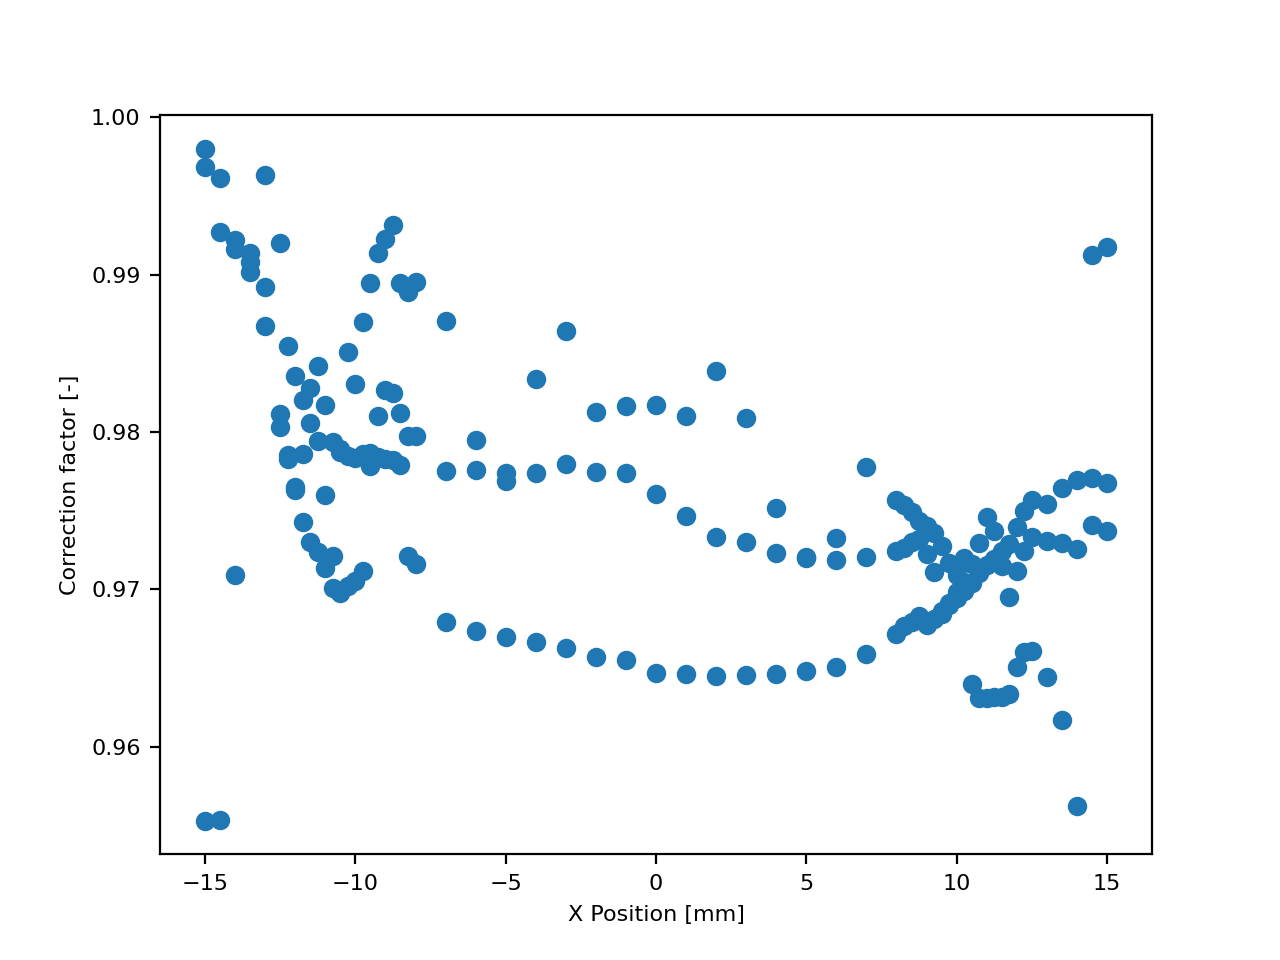

In [11]:
integrals = normaliseIntegrals(d,integrals)
d['pinNorm'] = d['pinDiode'] / d['diamondMonitor']

## 5. Collate data from various scans together 
Following notes in logbook. Signal trapping corrections, which are more complex and depend on sample geometry, will be applied later.

In [12]:
def procAndCol(can,scans,group=None):
    
    # Skip empty data
    if len(scans) == 0: return
    
    # Check for duplicate scan nos
    if len(scans) != len(set(scans)):
        print("* Error duplicate scan numbers in `%s` ABORT" % can)
        return
    
    # Open output file
    with h5py.File('%s.h5' % can, 'a') as Hout:
        
        # Check for subgroup, abort if pre-existing
        if group is None: G=Hout
        elif group in Hout: 
            print("* %s already exists, not writing to %s.h5" % (group,can))
            return
        else: G=Hout.create_group(group)
            
        print("Writing %s to %s.h5" % (group,can))
        
        # Loop scans
        for s in scans:
            d=readScan("processed_data/7bmb1_%04i.h5" % s)
            integrals, snr, peakenergy = integratePeaks(d,showSamplePlots=False)
            integrals = normaliseIntegrals(d,integrals, showSamplePlot=False)
        
            # Loop variables to write
            for k in d.keys():
                n = '%s/Scan_%04i' % (k,s)
                if n in G: 
                    print(" - %s already exists in %s.h5 [%s] ABORT" % (n,can,group))
                    return
                G.create_dataset(n , data=d[k], compression='gzip')
            for k in integrals.keys():
                G.create_dataset('%s/integral/Scan_%04i' % (k,s), data=integrals[k], compression='gzip')
                G.create_dataset('%s/snr/Scan_%04i' % (k,s), data=snr[k], compression='gzip')
                G.create_dataset('%s/peakEnergy/Scan_%04i' % (k,s), data=peakenergy[k], compression='gzip')
        
    return

## KI Solution scans

In [55]:
# Solutions #######################################################################################
can = '134 E8 KI Canister 1'
Vscans = (4049,4051,4053,4055,4057,4059,4061,4063,4065,4067,4069,4071,4073,4075,4078,4080,4082,4084,4086,4088,4090)
Hscans = (4050,4052,4054,4056,4058,4060,4062,4064,4066,4068,4070,4072,4074,4076,4079,4081,4083,4085,4087,4089,4091)
Sscans = (4354,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '152 E8 KI Canister 3'
Vscans = (4094,4097,4099,4101,4103,4105,4107,4109,4111,4113,4115,4117,4119,4121,4123,4125,4127,4129,4132,4134,4136,4138,4140,4142)
Hscans = (4095,4096,4098,4100,4102,4104,4106,4108,4110,4112,4114,4116,4118,4120,4122,4124,4126,4128,4133,4135,4137,4139,4141,4143)
Sscans = (4355,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '1234 E8 KI Canister 3'
Vscans = (4148,4150,4152,4154,4156,4158,4160,4162,4164,4166,4168,4170,4172,4174,4176,4178,4180,4182,4184,4186,4188)
Hscans = (4149,4151,4153,4155,4157,4159,4161,4163,4165,4167,4169,4171,4173,4175,4177,4179,4181,4183,4185,4187,4189)
Sscans = (4356,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '1234 E8 KI Canister 4'
Vscans = (4190,4192,4194,4196,4199)
Hscans = (4191,4193,4195,4197,4200)
Sscans = (4361,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = 'KIemptyReference'
Vscans = (4201,4202)
Hscans = (4203,4204)
Sscans = ()
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '134 E8 KI Canister 2'
Vscans = (4206,4208,4210,4212,4214)
Hscans = (4207,4209,4211,4213,4215)
Sscans = (4359,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '152 E8 KI Canister 9'
Vscans = (4216,4218,4220,4222,4224,4226)
Hscans = (4217,4219,4221,4223,4225,4227)
Sscans = (4360,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '134 E8 KI Canister 13'
Vscans = (4228,4230,4232,4235,4238)
Hscans = (4229,4231,4233,4234,4236,4237,4239,4240)
Sscans = ()
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '152 E8 KI Canister 10'
Vscans = (4241,4243,4245,4247,4250,4254,)
Hscans = (4242,4244,4246,4248,4251,4252,4255,4256)
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

# UpCounter2 now active from this point.
# These scans were performed at an offset x=-1.8mm due to mistake in zeroing.
can = '1234 E8 KI Canister 11' 
Vscans = (4257,4259,4261,4263,4265,4267)
Hscans = (4258,4260,4262,4264,4266,4268)
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

* VerticalScans already exists, not writing to 134 E8 KI Canister 1.h5
* HorizontalScans already exists, not writing to 134 E8 KI Canister 1.h5
* SumpScans already exists, not writing to 134 E8 KI Canister 1.h5
* VerticalScans already exists, not writing to 152 E8 KI Canister 3.h5
* HorizontalScans already exists, not writing to 152 E8 KI Canister 3.h5
* SumpScans already exists, not writing to 152 E8 KI Canister 3.h5
* VerticalScans already exists, not writing to 1234 E8 KI Canister 3.h5
* HorizontalScans already exists, not writing to 1234 E8 KI Canister 3.h5
* SumpScans already exists, not writing to 1234 E8 KI Canister 3.h5
* VerticalScans already exists, not writing to 1234 E8 KI Canister 4.h5
* HorizontalScans already exists, not writing to 1234 E8 KI Canister 4.h5
* SumpScans already exists, not writing to 1234 E8 KI Canister 4.h5
* VerticalScans already exists, not writing to KIemptyReference.h5
* HorizontalScans already exists, not writing to KIemptyReference.h5
* VerticalScan

In [7]:
can = '134 E8 KI Canister 1'
Vscans = (4049,4051,4053,4055,4057,4059,4061,4063,4065,4067,4069,4071,4073,4075,4078,4080,4082,4084,4086,4088,4090)
Hscans = (4050,4052,4054,4056,4058,4060,4062,4064,4066,4068,4070,4072,4074,4076,4079,4081,4083,4085,4087,4089,4091)
Sscans = (4354,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

Writing VerticalScans to 134 E8 KI Canister 1.h5


/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Writing HorizontalScans to 134 E8 KI Canister 1.h5


/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_76452/2394854970.py:4: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.nansum(residuals**2) / ss_tot)


Writing SumpScans to 134 E8 KI Canister 1.h5


## BaSO4 suspensions

In [13]:
# Suspensions #######################################################################################
# These are vertical scans w/outer dimension as time, giving a 2D scan record.
can = 'BaSO4emptyReference'
Vscans = ()
Hscans = (4284,)
Sscans = ()
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '134 BaSO4 Canister 5'
Vscans = range(4286,4294)
Hscans = ()
Sscans = (4351,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '152 BaSO4 Canister 7'
Vscans = (4294,4296,4297,4298,4299,4300)
Sscans = (4352,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '1234 BaSO4 Canister 11' # suspect valve
Vscans = (4302,4303,4305,4306,4307,4308,4310,4311)
Sscans = (4353,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

# These are horizontal scans w/outer dimension as time, giving a 2D scan record.
can = '134 BaSO4 Canister 7'
Vscans = ()
Hscans = (4314,4315,4316,4317)
Sscans = (4357,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '152 BaSO4 Canister 8'
Hscans = (4323,4324,4325,4326,4328)
Sscans = (4358,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '1234 BaSO4 Canister 12' # 4337-8 at high resolution
Hscans = (4330,4331,4332)
Sscans = (4362,) # Sump/Orifice
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Vscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '1234 BaSO4 Canister 13'
Hscans = (4333,4334)
Sscans = ()
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '152 BaSO4 Canister 9'
Hscans = (4336,4339,4340,4341,4342)
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '134 BaSO4 Canister 8'
Hscans = (4344,4345,4346,4347,4348)
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

can = '152 BaSO4 Canister 10'
Vscans = (4363,4364)
Hscans = (4365,4366)
procAndCol(can,Vscans,'VerticalScans'); procAndCol(can,Hscans,'HorizontalScans'); procAndCol(can,Sscans,'SumpScans')

* HorizontalScans already exists, not writing to BaSO4emptyReference.h5
* VerticalScans already exists, not writing to 134 BaSO4 Canister 5.h5
* SumpScans already exists, not writing to 134 BaSO4 Canister 5.h5
* VerticalScans already exists, not writing to 152 BaSO4 Canister 7.h5
* SumpScans already exists, not writing to 152 BaSO4 Canister 7.h5
* VerticalScans already exists, not writing to 1234 BaSO4 Canister 11.h5
* SumpScans already exists, not writing to 1234 BaSO4 Canister 11.h5
* HorizontalScans already exists, not writing to 134 BaSO4 Canister 7.h5
* SumpScans already exists, not writing to 134 BaSO4 Canister 7.h5
* HorizontalScans already exists, not writing to 152 BaSO4 Canister 8.h5
* SumpScans already exists, not writing to 152 BaSO4 Canister 8.h5
* SumpScans already exists, not writing to 1234 BaSO4 Canister 12.h5
* HorizontalScans already exists, not writing to 1234 BaSO4 Canister 13.h5
Writing HorizontalScans to 152 BaSO4 Canister 9.h5


/usr/local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


* HorizontalScans already exists, not writing to 134 BaSO4 Canister 8.h5
* VerticalScans already exists, not writing to 152 BaSO4 Canister 10.h5
* HorizontalScans already exists, not writing to 152 BaSO4 Canister 10.h5
